# Off-target analysis of Cas9-NG and SpG

The purpose of this notebook is to analyze the off-target profiles of Cas9-NG and SpG. This notebook is adapted from PCD's CFD code. We produce Figure 4 and Supplementary Fig 5 with this notebook. 

In [1]:
import pandas as pd
import seaborn as sns
import gpplot 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy import stats
import random
from sklearn.metrics import auc
import warnings
import gpplot as gpplot
warnings.filterwarnings('ignore')

# Set default settings for plotting
sns.set_style('ticks')
sns.set_context('talk')
mpl.rc('pdf', fonttype=42)
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

In [4]:
lfc_df = pd.read_table('../data_files/Fig 4_PAM flex off-targets/processed/PAMflex_off-target_CP1559_avglfc_v1.txt')
# Read in Supplementary Data 3
meta_information = pd.read_excel('../data_files/Fig 4_PAM flex off-targets/raw/Supplementary_Data3_v3.xlsx', sheet_name='Library annotation')
pam_activity = pd.read_table('../data_files/Fig 1_3_PanPAM on-target/processed/fractionactive_allsgRNA_v1.txt')
pam_list_ng = pd.read_csv('../data_files/pam_lists/2021-05-11_PAM list 4_v2.csv')
pam_list_spg = pd.read_csv('../data_files/pam_lists/2021-05-11_PAM list 5_v2.csv')

## QC and Data Munging
First, we clean up some of the meta-information files, adding one to the mismatch position of G19 sgRNAs

In [5]:
#pams that are intermediate + active with BOTH SpG and NG 

pam_list = pd.merge(pam_list_ng, pam_list_spg, on='PAM', how='inner')
len(pam_list)

56

In [6]:
def get_guide_type(row):
    if row['Length of WT Sequence'] == 19:
        return 'G19'
    elif row['G20_x'] == 'y':
        return 'G20'
    else:
        return 'g20'

def align_mismatch_pos(row):
    if row['Mismatch Position'] == 'none':
        mismatch = 'none'
    elif row['guide_type'] == 'G19':
        mismatch = ','.join([str(int(pos) + 1) for pos in row['Mismatch Position'].split(',')])
    else: 
        mismatch = row['Mismatch Position']
    return mismatch
    
meta_information['guide_type'] = meta_information.apply(lambda df: get_guide_type(df), axis=1)
breif_meta = (meta_information[['WT Sequence', 'Mismatch Sequence', 'Reference Sequence', 'Context_x', 
                                'N_PAM', 'PAM_x', 'Gene_x', 'guide_type', 'Number of mismatches', 'Mismatch Position',
                                'Type of Mismatch']]
              .rename({'Context_x': 'Context', 'PAM_x':'PAM', 'Gene_x': 'Gene'}, axis=1))
breif_meta['Mismatch Position'] = breif_meta.apply(align_mismatch_pos, axis=1)

In [7]:
lfc_meta = (lfc_df.rename({'A375_CP1559_RDA275_Rep A': 'NG Rep_A', 
                           'A375_CP1559_RDA275_Rep B': 'NG Rep_B', 
                           'A375_CP1559_RDA275_AVGLFC_frompDNA': 'NG avg_lfc', 
                          'A375_CP1559_RDA449_Rep A' : 'SpG Rep_A',
                          'A375_CP1559_RDA449_Rep B' : 'SpG Rep_B',
                          'A375_CP1559_RDA449_AVGLFC_frompDNA' : 'SpG avg_lfc'},axis=1).merge(breif_meta, left_on='Construct Barcode', right_on='Reference Sequence', how='inner'))

Supplementary Fig 5a

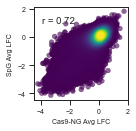

In [8]:
gpplot.set_aesthetics(context='paper')

plt.subplots(figsize=(1.7,1.7))
gpplot.point_densityplot(data=lfc_meta, x='NG avg_lfc', y='SpG avg_lfc')
gpplot.add_correlation(data=lfc_meta, x='NG avg_lfc', y='SpG avg_lfc')
plt.xlabel('Cas9-NG Avg LFC', fontsize=7)
plt.ylabel('SpG Avg LFC', fontsize=7)
plt.tick_params(axis='both', labelsize=7)
#plt.savefig('../../../Figures/panels/Fig 4/ng_spg_offtarget_scatter.pdf', dpi=1000, bbox_inches='tight', transparent=True)

In [9]:
print(len(lfc_meta))

78058


## Calculating the probability that each guide is active

The perfect match guides are slightly less active than we might expect, so, we'll filter for guides with more acitivity, included in the PAM list 3 for Cas9 variants

In [12]:
long_lfcs = (lfc_meta.melt(id_vars=['Construct Barcode', 'Construct IDs',
                                         'WT Sequence', 'Reference Sequence',
                                         'PAM', 'Number of mismatches', 'guide_type',
                                         'Type of Mismatch', 'Mismatch Position'],
                                value_vars=['NG avg_lfc',
                                            'SpG avg_lfc'],
                                var_name='condition', value_name='lfc')
             .rename({'Construct IDs': 'Target ID'}, axis=1))

long_lfcs['Number of mismatches'] = long_lfcs['Number of mismatches'].replace({'none' : 'Perfect Match',
                                                                              'single' : 'Single',
                                                                              'double': 'Double',
                                                                              'Control': 'Non-targeting Control'})
long_lfcs['Number of mismatches'] = pd.Categorical(long_lfcs['Number of mismatches'], 
                                                   categories=['Perfect Match', 'Single', 'Double', 'Non-targeting Control'])

In [13]:
color_dictionary = dict({'Non-targeting Control':'#8da0cb',
                  'Double':'#fc8d62',
                  'Single': '#66c2a5',
                  'Perfect Match': '#e78ac3'})

In [14]:
spg_long = long_lfcs[long_lfcs['condition'] == 'SpG avg_lfc']


Supplementary Fig 5b, unfiltered PAMs

Text(0.5, 0.98, 'SpG')

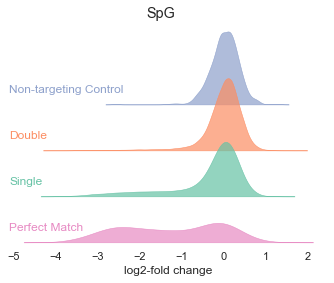

In [15]:
#with all PAMs
g = gpplot.ridgeplot(spg_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('SpG')
#plt.savefig('../../../Figures/panels/Fig 4/SpG_ridge_entire_lib.pdf', bbox_inches ='tight', dpi = 1000, transparent='True')

In [16]:
ng_long = long_lfcs[long_lfcs['condition'] == 'NG avg_lfc']


Text(0.5, 0.98, 'Cas9-NG')

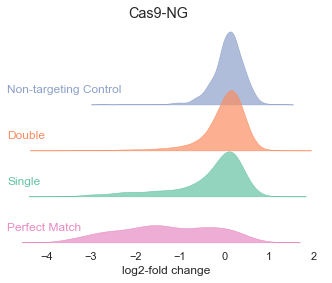

In [17]:
#with all PAMs
g = gpplot.ridgeplot(ng_long, 'lfc','Number of mismatches', palette=color_dictionary,
                     row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('log2-fold change')
plt.suptitle('Cas9-NG')

In [22]:
#Filter for active PAMs
filt = 'shared_pams'
if filt == 'shared_pams':
    filtered_lfcs = lfc_meta[lfc_meta['PAM'].isna() | lfc_meta['PAM'].isin(pam_list['PAM'])].copy() # Controls are NA
elif filt == 'top_wt_sgs':
    wt_sgs = lfc_meta[lfc_meta['Number of mismatches'] == 'none']
    top18_wt_sgs = wt_sgs[(wt_sgs
                           .groupby(['guide_type'])
                           ['avg_lfc']
                           .rank() <= 18)]
    filtered_lfcs = lfc_meta[lfc_meta['PAM'].isna() | lfc_meta['WT Sequence'].isin(top18_wt_sgs['WT Sequence'])].copy() # Controls are NA

In [23]:
filtered_lfcs['Number of mismatches'].value_counts()

double     29877
single      8809
Control      989
none         149
Name: Number of mismatches, dtype: int64

In [24]:
filt = 'shared_pams'
if filt == 'shared_pams':
    filtered_long_lfcs = long_lfcs[long_lfcs['PAM'].isna() | long_lfcs['PAM'].isin(pam_list['PAM'])].copy() # Controls are NA
elif filt == 'top_wt_sgs':
    wt_sgs = long_lfcs[long_lfcs['Number of mismatches'] == 'none']
    top18_wt_sgs = wt_sgs[(wt_sgs
                           .groupby(['guide_type'])
                           ['avg_lfc']
                           .rank() <= 18)]
    filtered_long_lfcs = long_lfcs[long_lfcs['PAM'].isna() | long_lfcs['WT Sequence'].isin(top18_wt_sgs['WT Sequence'])].copy() # Controls are NA

When we filter for the most active PAMs, we see a greater separation between perfect matches and controls. Figure 4b

In [27]:
color_dictionary = dict({'Non-targeting Control':'#8da0cb',
                  'Double':'#fc8d62',
                  'Single': '#66c2a5',
                  'Perfect Match': '#e78ac3'})

In [28]:
spg_filtered = filtered_long_lfcs[filtered_long_lfcs['condition'] == 'SpG avg_lfc']


Text(0.5, 0.98, 'SpG')

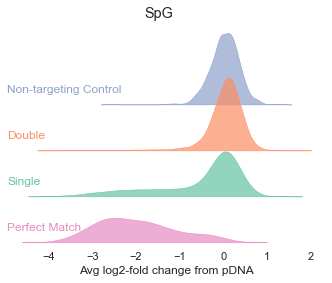

In [30]:
#with shared PAMs
g = gpplot.ridgeplot(spg_filtered, 'lfc', 'Number of mismatches', palette=color_dictionary,
                    row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
g.fig.subplots_adjust(hspace=-.4)
plt.xlabel('Avg log2-fold change from pDNA')
plt.suptitle('SpG')

In [31]:
ng_filtered = filtered_long_lfcs[filtered_long_lfcs['condition'] == 'NG avg_lfc']

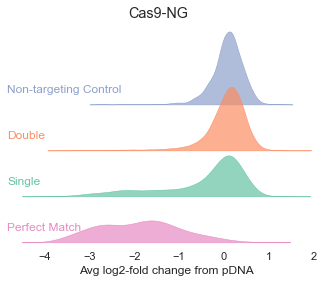

In [32]:
g = gpplot.ridgeplot(ng_filtered, 'lfc', 'Number of mismatches', palette=color_dictionary,
                    row_order = ['Non-targeting Control', 'Double', 'Single', 'Perfect Match'])
plt.xlabel('Avg log2-fold change from pDNA')
plt.suptitle('Cas9-NG')
g.fig.subplots_adjust(hspace=-.4)

## Calculate CFD matrices by 5'type

In [47]:
G19_cfd_ng = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'G19') & 
                              (single_mismatch_df['condition'] =='NG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
G19_cfd_ng['Mismatch Position'] = G19_cfd_ng['Mismatch Position'].astype(int)
G19_cfd_matrix = G19_cfd_ng.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                    columns='Mismatch Position')

In [48]:
G19_cfd_spg = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'G19') & 
                              (single_mismatch_df['condition'] =='SpG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
G19_cfd_spg['Mismatch Position'] = G19_cfd_spg['Mismatch Position'].astype(int)
G19_cfd_matrix = G19_cfd_spg.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                    columns='Mismatch Position')

In [49]:
g20_cfd_ng = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'g20') & 
                              (single_mismatch_df['condition'] =='NG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
g20_cfd_ng['Mismatch Position'] = g20_cfd_ng['Mismatch Position'].astype(int)
g20_cfd_matrix = g20_cfd_ng.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')

In [50]:
g20_cfd_spg = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'g20') & 
                              (single_mismatch_df['condition'] =='SpG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
g20_cfd_spg['Mismatch Position'] = g20_cfd_spg['Mismatch Position'].astype(int)
g20_cfd_matrix = g20_cfd_spg.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')

In [51]:
G20_cfd_ng = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'G20') &
                             (single_mismatch_df['condition'] =='NG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
G20_cfd_ng['Mismatch Position'] = G20_cfd_ng['Mismatch Position'].astype(int)
G20_cfd_matrix = G20_cfd_ng.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')

In [53]:
G20_cfd_spg = (single_mismatch_df[(single_mismatch_df['guide_type'] == 'G20') &
                             (single_mismatch_df['condition'] =='SpG avg_lfc')]
                                          .groupby(['Type of Mismatch', 'Mismatch Position'])
                                          .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                          .reset_index())
G20_cfd_spg['Mismatch Position'] = G20_cfd_spg['Mismatch Position'].astype(int)
G20_cfd_matrix = G20_cfd_spg.pivot_table(values='avg_active_prob_single', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')

## Calculate a single CFD matrix for each enzyme 

Figure 4d

In [54]:
G20_cfd_ng['condition'] = 'Cas9-NG_G20'
G19_cfd_ng['condition'] = 'Cas9-NG_G19'
g20_cfd_ng['condition'] = 'Cas9-NG_g20'
ng_output_df = (pd.concat([G20_cfd_ng, G19_cfd_ng, g20_cfd_ng])
             .sort_values(['condition', 'Mismatch Position', 'Type of Mismatch'])
             .rename({'avg_active_prob_single': 'prob_active'}, axis=1))

In [55]:
G20_cfd_spg['condition'] = 'Cas9-SpG_G20'
G19_cfd_spg['condition'] = 'Cas9-SpG_G19'
g20_cfd_spg['condition'] = 'Cas9-SpG_g20'
spg_output_df = (pd.concat([G20_cfd_spg, G19_cfd_spg, g20_cfd_spg])
             .sort_values(['condition', 'Mismatch Position', 'Type of Mismatch'])
             .rename({'avg_active_prob_single': 'prob_active'}, axis=1))

Text(0.5, 1.0, 'SpG')

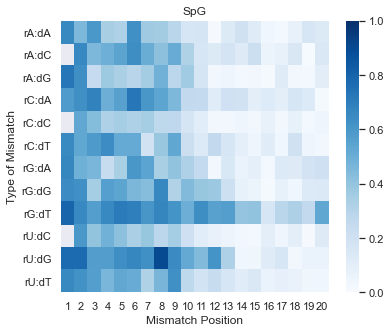

In [56]:
gpplot.set_aesthetics(context='paper')
sns.set(rc={'figure.figsize':(6,5)})
spg_output_df['Mismatch Position'] = spg_output_df['Mismatch Position'].astype(int)
spg_output_matrix = spg_output_df.pivot_table(values='prob_active', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')
sns.heatmap(spg_output_matrix, cmap='Blues', vmin=0, vmax=1)

plt.title('SpG')

Text(0.5, 1.0, 'NG')

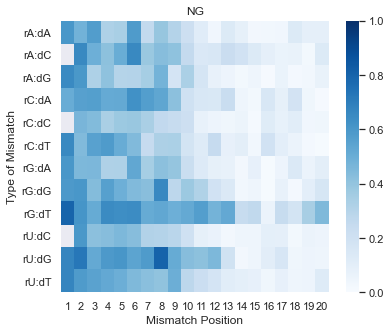

In [58]:
gpplot.set_aesthetics(context='paper')
sns.set(rc={'figure.figsize':(6,5)})
ng_output_df['Mismatch Position'] = ng_output_df['Mismatch Position'].astype(int)
ng_output_matrix = ng_output_df.pivot_table(values='prob_active', index='Type of Mismatch', 
                                                                     columns='Mismatch Position')
sns.heatmap(ng_output_matrix, cmap='Blues', vmin=0, vmax=1)
plt.title('NG')

Supplementary Figure 5c,d

In [59]:
def build_logistic_model(data, activity_col, category_col, active_category):
    model = LogisticRegression(random_state=7)
    X = data[[activity_col]]
    y = data[category_col] == active_category
    model.fit(X, y)
    return model

def get_probability_active(data, activity_col, category_col, active_category, inactive_category):
    model_matrix = data[data[category_col].isin([active_category, inactive_category])]
    model = build_logistic_model(model_matrix, activity_col, category_col, active_category)
    data['active_probability'] = model.predict_proba(data[[activity_col]])[:,1] # 1 == active
    return data
    
active_probability_df =  get_probability_active(filtered_long_lfcs, 'lfc', 'Number of mismatches', 'Perfect Match', 'Non-targeting Control')



In [60]:
single_mismatch_df = active_probability_df[active_probability_df['Number of mismatches'] == 'Single'].copy()

In [61]:
def add_xy_line(slope=1, intercept=0, ax=None, linestyle='dashed', linecolor='black', xlim=None):
    """Add line with specified slope and intercept to a scatter plot; Default: y=x line
    Parameters
    ----------
    slope: float
        Value of slope of line to be drawn
    intercept: float
        Value of intercept of line to be drawn
    ax: Axis object, optional
        Plot to add line to
    linestyle: str, optional
        Style of line
    linecolor: str, optional
        Color of line
    Returns
    -------
    matplotlib.axes.Axes
    """
    if ax is None:
        ax = plt.gca()
    if xlim is None:
        xlim = ax.get_xlim()
    x = np.array(xlim)
    y = intercept + slope * x
    ax = ax.plot(x, y, linestyle=linestyle, color=linecolor)
    return ax

def scatter_comparison(data, x, y, ax, hue='Mismatch Position', palette='viridis', legend=False):
    sns.scatterplot(data=data, x=x, y=y,hue=hue, palette=palette, ax=ax, legend=legend, linewidth=0)
    #ax.legend(facecolor='white', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    gpplot.add_correlation(data=data.dropna(), x=x, y=y, ax=ax, loc='lower right')
    sns.despine()
    add_xy_line(ax=ax, xlim=(0,1))

In [62]:
spread_probabilities_g_status = (single_mismatch_df.pivot_table(index=['Type of Mismatch', 'Mismatch Position', 'condition'],
                                                                columns=['guide_type'], values='active_probability')
                                 .reset_index())
spread_probabilities_g_status['Mismatch Position'] = spread_probabilities_g_status['Mismatch Position'].astype(int)

When we plot each square in the CFD matrix as a point, representing the position of the mismatch by color, we see that g20 guides are least the promiscuous followed by G20 and then G19. These plots make up Supp Fig 5c,d 

Text(0.5, 0.65, 'Cas9-NG')

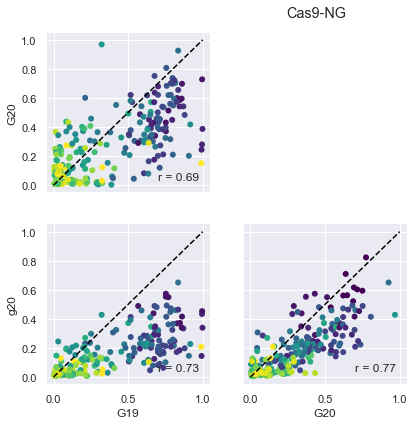

In [64]:
ng = spread_probabilities_g_status[spread_probabilities_g_status['condition'] == 'NG avg_lfc']
conditions = ['G19', 'G20', 'g20']
fig, axs = plt.subplots(nrows=len(conditions), ncols=len(conditions), figsize=(10,10), sharex=True, sharey=True)
for i in range(len(conditions)):
    for j in range(len(conditions)):
        ax = axs[i, j]
        if i > j:
            x = conditions[i]
            y = conditions[j]  
            scatter_comparison(ng, y, x, ax)
        else:
            ax.remove()
fig.suptitle('Cas9-NG', y=0.65)

Text(0.5, 0.65, 'SpG')

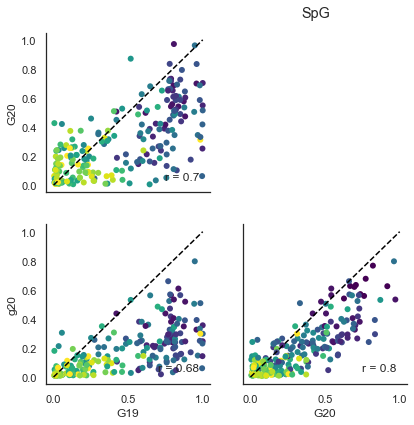

In [41]:
spg = spread_probabilities_g_status[spread_probabilities_g_status['condition'] == 'SpG avg_lfc']
conditions = ['G19', 'G20', 'g20']
fig, axs = plt.subplots(nrows=len(conditions), ncols=len(conditions), figsize=(10,10), sharex=True, sharey=True)
for i in range(len(conditions)):
    for j in range(len(conditions)):
        ax = axs[i, j]
        if i > j:
            x = conditions[i]
            y = conditions[j]  
            scatter_comparison(spg, y, x, ax)
        else:
            ax.remove()
fig.suptitle('SpG', y=0.65)

In [65]:
single_mismatch_active_probability = (active_probability_df[active_probability_df['Number of mismatches'] == 'Single']
                                      .groupby(['Type of Mismatch', 'Mismatch Position', 'condition'])
                                      .agg(avg_active_prob_single = ('active_probability', 'mean'))
                                      .reset_index())
single_mismatch_active_probability['Mismatch Position'] = single_mismatch_active_probability['Mismatch Position'].astype(int)
spread_single_mismatch = (single_mismatch_active_probability.pivot_table(values='avg_active_prob_single', 
                                                                         index=['Type of Mismatch', 'Mismatch Position'], 
                                                                         columns=['condition'])
                          .reset_index())
spread_single_mismatch['Mismatch Position'] = spread_single_mismatch['Mismatch Position'].astype('int')

In [66]:
spread_single_mismatch = spread_single_mismatch.rename(columns = {'NG avg_lfc' : 'Cas9-NG',
                                                       'SpG avg_lfc': 'SpG'})


In [67]:
gpplot.set_aesthetics(context= 'paper', palette='Set2')

FIgure 4e

Text(0, 0.5, 'SpG \n probability of being active')

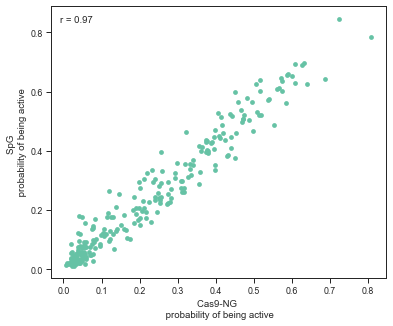

In [68]:
gpplot.set_aesthetics(context='paper')
sns.scatterplot(data=spread_single_mismatch, x="Cas9-NG", y="SpG", linewidth=0)
gpplot.add_correlation(data=spread_single_mismatch, x="Cas9-NG", y="SpG")
sns.set(rc={'figure.figsize':(3,3)})
plt.xlabel('Cas9-NG \n probability of being active')
plt.ylabel('SpG \n probability of being active')

## Metric for comparing off-target activity

Figure 4c

Off-target: perfect match vs single or double


In [69]:
def get_roc_auc(df, col):
    df = df.sort_values(by=col)
    df['true-pos_cumsum'] = np.cumsum(df['ess-val'])
    #print(df['true-pos_cumsum'])
    df['false-pos_cumsum'] = np.cumsum(df['non-ess-val'])
    df['fpr'] = df['false-pos_cumsum']/(df['false-pos_cumsum'].iloc[-1])
    df['tpr'] = df['true-pos_cumsum']/(df['true-pos_cumsum'].iloc[-1])
    df.head()
    roc_auc = auc(df['fpr'],df['tpr'])
    roc_df = pd.DataFrame({'False_Positive_Rate':list(df.fpr), 'True_Positive_Rate':list(df.tpr)})
    return roc_auc, roc_df

## Single mismatches 

In [74]:
perfect_single = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'single')]

In [75]:
perfect_single['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_single.iterrows()]
perfect_single['non-ess-val'] = [1 if r['Number of mismatches'] == 'single' else 0 for i,r in perfect_single.iterrows()]

In [76]:
ng_single_auc, ng_single_roc = get_roc_auc(perfect_single, 'NG avg_lfc')
ng_single_auc

0.8561903970999764

In [77]:
spg_single_auc, spg_single_roc = get_roc_auc(perfect_single, 'SpG avg_lfc')
spg_single_auc

0.855191571158539

## Double mismatches 

In [78]:
perfect_double = filtered_lfcs[(filtered_lfcs['Number of mismatches'] == 'none')
                              |(filtered_lfcs['Number of mismatches'] == 'double')]

In [79]:
perfect_double['ess-val'] = [1 if r['Number of mismatches'] == 'none' else 0 for i,r in perfect_double.iterrows()]
perfect_double['non-ess-val'] = [1 if r['Number of mismatches'] == 'double' else 0 for i,r in perfect_double.iterrows()]

In [80]:
ng_double_auc, ng_double_roc = get_roc_auc(perfect_double, 'NG avg_lfc')
ng_double_auc

0.9653860469985103

In [74]:
spg_double_auc, spg_double_roc = get_roc_auc(perfect_double, 'SpG avg_lfc')
spg_double_auc

0.9704445946501461

The above values were input into Prism to make Figure 4c